In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from scipy import integrate
from pyqcams import qct, constants, potentials, plotters, util, analysis

# Run one trajectory
## Input Dictionary
This is an example input for the reaction `H$_2$ + Ca $\rightarrow$ CaH + H`, where `H$_2$` is initialized in the v=3, j=3 state. The dictionary can be imported from the `inputs.py` file, or written directly as shown here.

First, create the QCT calculation input dictionary, which requires masses `mi`, collision energy `E0`, impact parameter `b0`, initial distance `R0`, all three `Molecule` objects `mol_ij`, 3-body potential `vt` and partial derivatives `dvtdrij`, and integration parameters `integ`. 

The `Molecule` object requires the respective masses `mi, mj`, diatiomic potential `Vij` and its derivative `dVij`, and range `xmin`,`xmax`. The molecule formed between atoms 1 and 2 is the initial molecule, thus needs initial rovibrational state (`vi`,`ji`), and number of DVR points `npts`. If the vibrational energy spectrum is known, `vi` and `npts` can be replaced by the keyword argument `Ei` in Hartree. 

In [3]:
# Define masses in a.u.
m1 = 1.008*constants.u2me
m2 = 1.008*constants.u2me
m3 = 40.078*constants.u2me

E0 = 40000 # collision energy (K)
b0 = 0 # Impact parameter
R0 = 50 # Initial distance in Bohr

# Potential parameters in atomic units
v12, dv12 = potentials.morse(de = 0.16456603489, re = 1.40104284795, alpha = 1.059493476908482) # H2
v23, dv23 = potentials.morse(de = 0.06529228457, re = 3.79079033313, alpha = 0.6906412379896358) # CaH
v31, dv31 = potentials.morse(de = 0.06529228457, re = 3.79079033313, alpha = 0.6906412379896358) # CaH

v123, dv123dr12, dv123dr23, dv123dr31 = potentials.axilrod(C=0) # CaH2

# Initiate molecules
mol12 = qct.Molecule(mi = m1, mj = m2, vi = 3, ji = 3,Vij = v12, dVij = dv12, 
                     xmin = .5, xmax = 30, npts=1000) # H2
mol23 = qct.Molecule(mi = m2, mj = m3, Vij = v23, dVij = dv23, xmin = 1, xmax = 40) # CaH
mol31 = qct.Molecule(mi = m3, mj = m1, Vij = v31, dVij = dv31, xmin = 1, xmax = 40) # CaH

input_dict = {'m1':m1,'m2':m2,'m3':m3,
    'E0': E0, 'b0': b0, 'R0': R0, 'seed': None,
    'mol_12': mol12,'mol_23': mol23,'mol_31': mol31,
    'vt': v123, 'dvtdr12': dv123dr12, 'dvtdr23': dv123dr23, 'dvtdr31': dv123dr31,
    'integ':{'t_stop': 4, 'r_stop': 2, 'r_tol': 1e-10, 'a_tol':1e-8,'econs':1e-5,'lcons':1e-5}}

## Study Potential Energy Curves
Before we run the trajectory, we should examine the potential functions describing the 3 potential molecules. We can calculate the energy spectrum of H2 using `Molecules.DVR`, and we can also plot the energy level.

In [4]:
evj = mol12.DVR() # Energy spectrum
mol12.turningPts(initial=True) # Set classical turning points

<IPython.core.display.Javascript object>


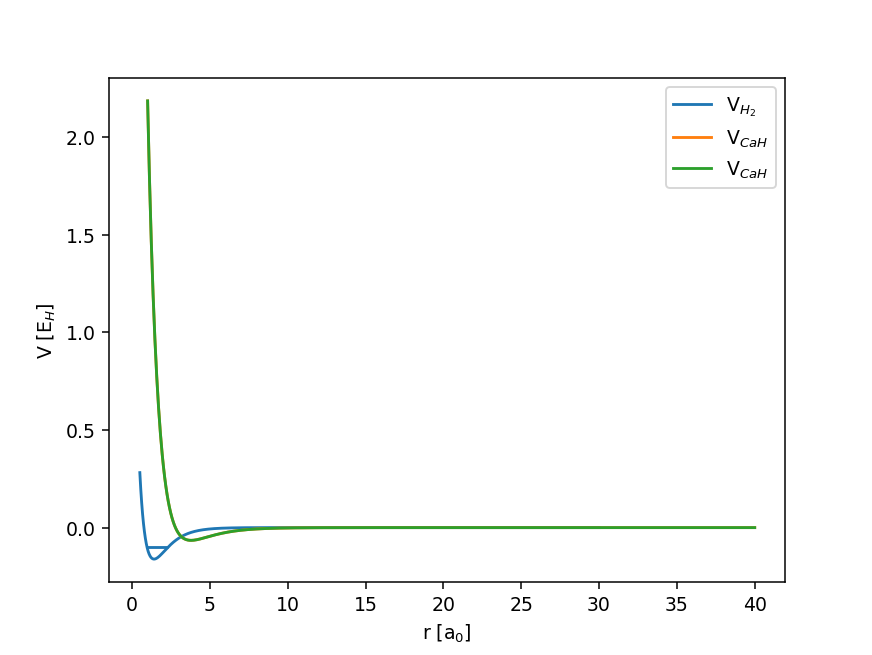

In [5]:
r12 = np.linspace(mol12.xmin,mol12.xmax,mol12.npts)
r23 = np.linspace(mol23.xmin,mol23.xmax,1000)
r31 = np.linspace(mol31.xmin,mol31.xmax,1000)
plt.figure()
plt.plot(r12,mol12.Veff(r12), label = r'V$_{H_2}$')
plt.hlines(mol12.Ei, mol12.rm,mol12.rp)
plt.plot(r23,mol23.Vij(r23), label = r'V$_{CaH}$')
plt.plot(r31,mol31.Vij(r31), label = r'V$_{CaH}$')
plt.xlabel(r'r [a$_0$]')
plt.ylabel(r'V [E$_H$]')
plt.legend()
plt.show()

We can run a trajectory and obtain an output by initializing a `Trajectory` object and calling `runT`. Then we can use the plotter tool to plot the trajectory in 2d and 3d. 

<IPython.core.display.Javascript object>


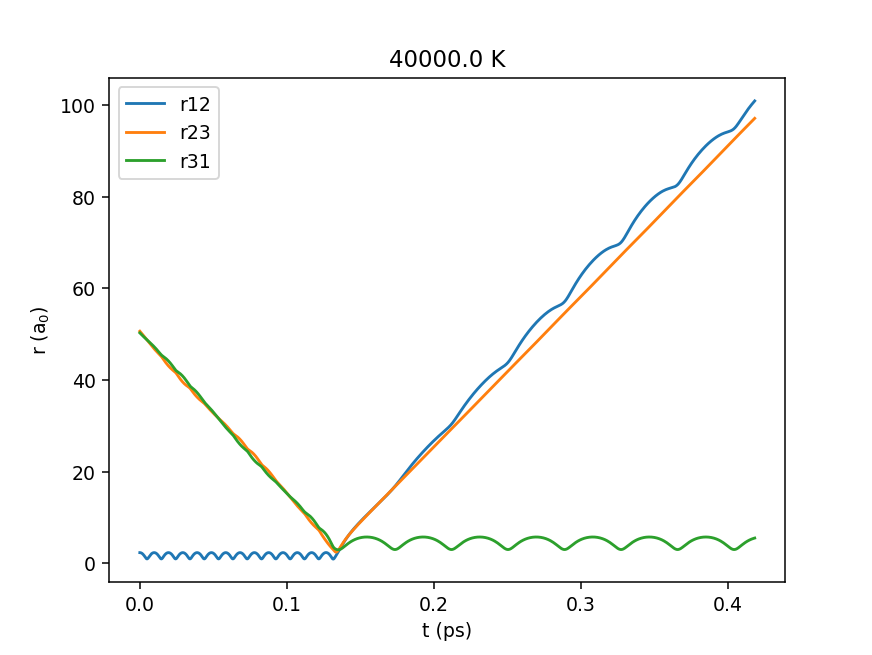

<IPython.core.display.Javascript object>


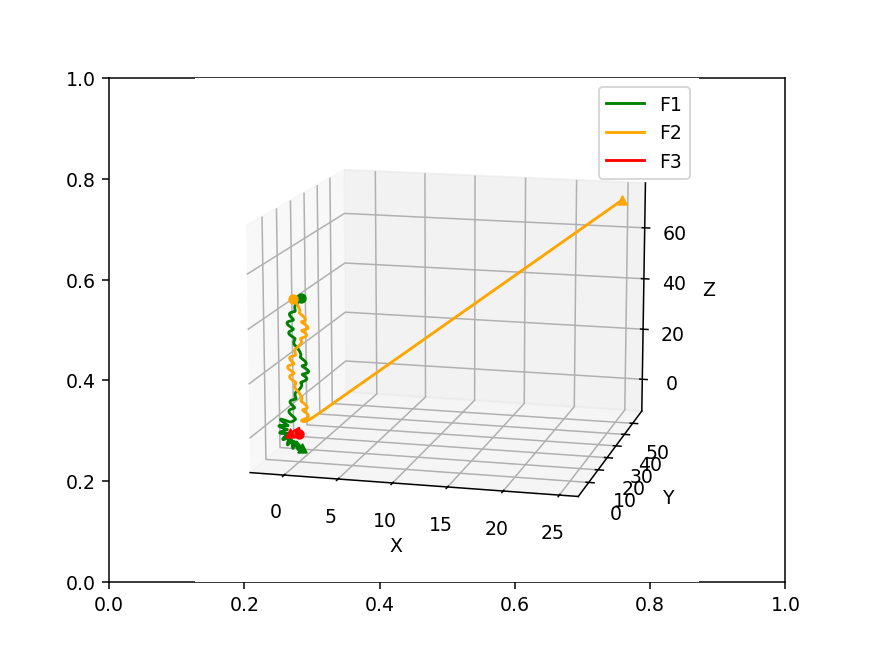

In [6]:
traj = qct.Trajectory(**input_dict)
traj.runT()
plt.figure()
plotters.traj_plt(traj)
plt.show()
plt.figure()
plotters.traj_3d(traj)
plt.show()


We can inspect the results using `util.get_results`, including any extra attributes such as `delta_e` and `delta_l`. 

In [7]:
attrs = ('delta_e','delta_l')
print(util.get_results(traj, *attrs))

{'e': 40000.0, 'b': 0, 'vi': 3.0, 'ji': 3, 'n12': 0, 'n23': 0, 'n31': 1, 'nd': 0, 'nc': 0, 'v': 7.0, 'vw': '1.039e-19', 'j': 7.0, 'jw': '1.979e-38', 'delta_e': 1.0456098972766448e-09, 'delta_l': -2.2715961112140803e-08}


## Plotting all products
The trajectory can end with three possibilities:
1. Quenching: Ca + H$_2$ $\rightarrow$ Ca + H$_2$
2. Reaction: Ca + H$_2$ $\rightarrow$ CaH + H
3. Dissociation: Ca + H$_2$ $\rightarrow$ Ca + H + H

In [8]:
quench = qct.Trajectory(**input_dict)
quench.runT()
n = 0
while (quench.count[0] == 0) and n < 100: # Filter for quenching
    quench.runT()
    n+=1

In [9]:
react = qct.Trajectory(**input_dict)
react.runT()
n = 0
while (react.count[1] == 0 and react.count[2] == 0) and n < 100: # Filter for forming CaH
    react.runT()
    n+=1

In [10]:
diss = qct.Trajectory(**input_dict)
diss.runT()
n = 0
while (diss.count[3] == 0) and n < 100: # Filter for forming CaH
    diss.runT()
    n+=1

<IPython.core.display.Javascript object>


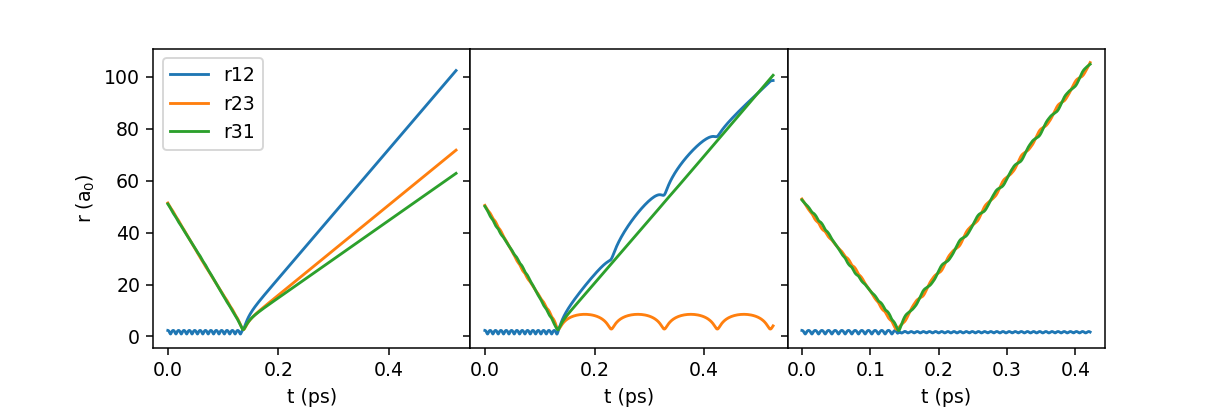

In [11]:
fig, ax = plt.subplots(1,3, sharey=True,figsize=(9,3))
ax.ravel()
plotters.traj_plt(diss, title=False, legend=True, ax = ax[0])
plotters.traj_plt(react, title=False, legend=False, ax = ax[1])
plotters.traj_plt(quench, title=False, legend=False, ax = ax[2])
plt.subplots_adjust(wspace=0, bottom = 0.15)
for i,v in enumerate(ax):
    ax[i].set_xlabel('t (ps)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
fig.subplots_adjust(wspace=0)
# plt.tight_layout(w_pad=0)
plt.show()

## Parallel Run
For the same initial state, use the `runN` method to run `nTraj` number of trajectories using all available CPUs. This can be controlled with the `cpus` argument. You can save to short and long output files, and request `Trajectory` attributes with argument `attrs` to save them to the long output. This can be done directly in the input file. 

In [32]:
nTraj = 10
bvals = 10
short_out = 'results/sampleshort.txt'
long_out = 'results/samplelong.txt'
### Run over a range of impact parameters ###
bi = np.arange(0,5,.25)
for b in bi:
    input_dict['b0'] = b
    qct.runN(nTraj,input_dict,attrs=('delta_e',),short_out=short_out, long_out=long_out)

## Analysis
Use the provided analysis functions for the state-specific opacity,cross section, and rate coefficients of the reaction. The columns are indexed according to the final outcome, where `R` represents a reaction, `Q` represents quenching, and `Diss` represents dissociation. The error is also included for each outcome. In this example we use Gaussian Binning, and look for the vibrational state-specific results from H$_2$ initialized in the (v=0,j=0) state. 

In [13]:
mu = m3*(m1+m2)/(m1+m2+m3)
opacity = analysis.opacity('results/v0j0_long.txt',GB=True,vib=True,rot=False)
sigma = analysis.crossSection('results/v0j0_long.txt',GB=True,vib=True,rot=False)
rate = analysis.rate('results/v0j0_long.txt',mu=mu,GB=True,vib=True,rot=False)

In [15]:
opacity.head()

v            pR        pR_err        pQ        pQ_err  \
vi  ji e       b                                                              
0.0 0  15000.0 0.0  0.0  1.369258e-38  1.663575e-21  0.520588  1.663575e-21   
               2.0  0.0  0.000000e+00  0.000000e+00  0.433948  0.000000e+00   
               2.2  0.0  0.000000e+00  0.000000e+00  0.387952  0.000000e+00   
               2.4  0.0  0.000000e+00  0.000000e+00  0.412545  0.000000e+00   
               2.6  0.0  0.000000e+00  0.000000e+00  0.450101  0.000000e+00   

                       pDiss  pDiss_err  
vi  ji e       b                         
0.0 0  15000.0 0.0  0.000606   0.000350  
               2.0  0.000918   0.000459  
               2.2  0.000000   0.000000  
               2.4  0.000751   0.000434  
               2.6  0.000220   0.000220

Check that the opacity function is continuous, with a clearly defined maximum impact parameter. Here we sum over the final v states to get the full opacity at a given collision energy.

<IPython.core.display.Javascript object>


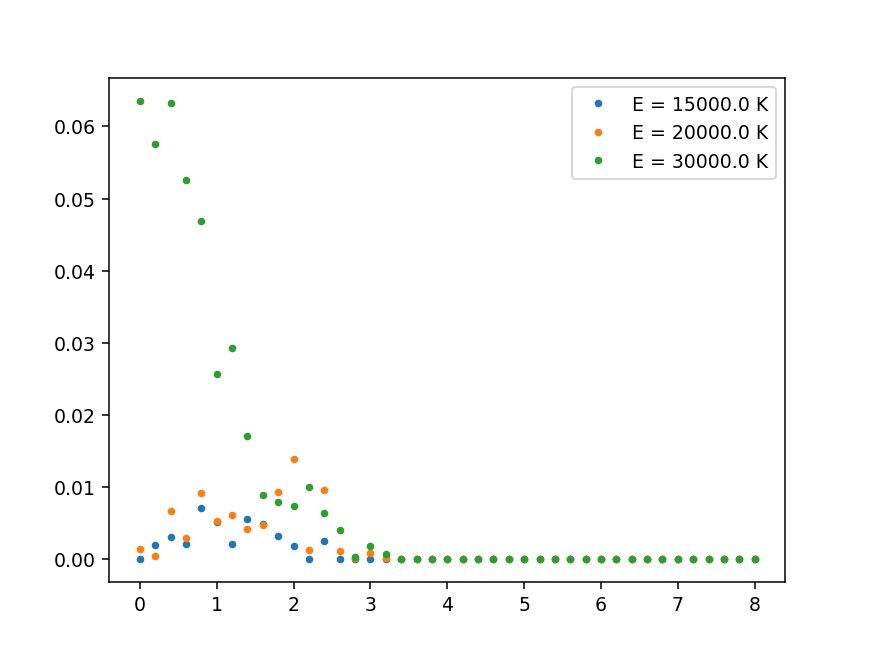

In [16]:
o = opacity.reset_index()
pR = o.groupby(['vi','ji','e','b'])['pR'].sum().reset_index()
plt.figure()
for ev in pR.e.unique():
    pR_e = pR[pR['e']==ev]
    plt.plot(pR_e['b'],pR_e['pR'],'.',label=f'E = {ev} K')
plt.legend()
plt.show()

Since we kept track of the final vibrational states, we can look into the distribution of CaH(v$_f$,j).

<IPython.core.display.Javascript object>


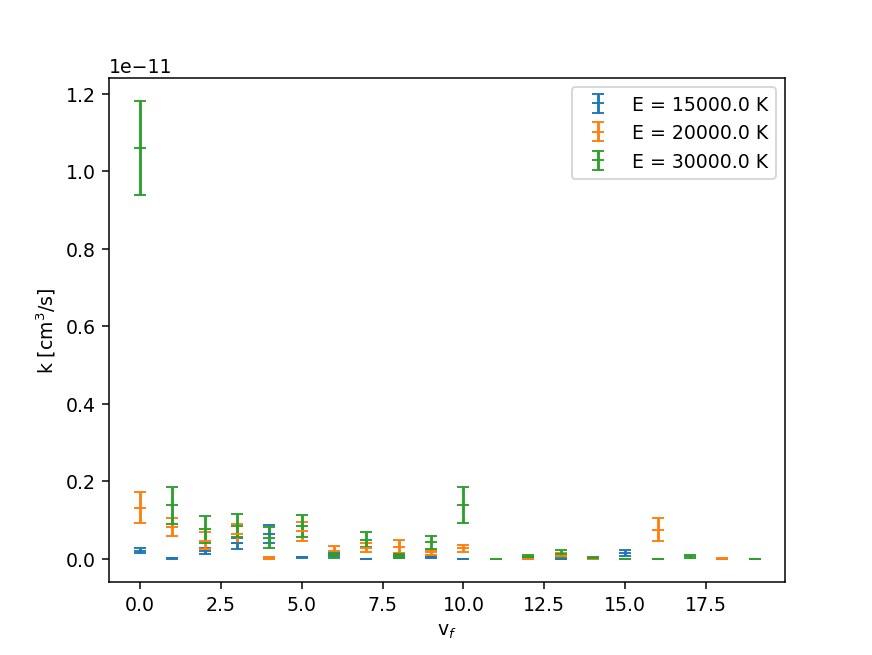

In [18]:
r = rate.reset_index('e')
plt.figure()
for ev in r.e.unique():
    re = r[r['e'] == ev]
    plt.errorbar(re['v'],re['k_R'],re['k_Rerr'], fmt = '_', capsize=3, label = f'E = {ev:.1f} K')
plt.xlabel(r'v$_f$')
plt.ylabel(r'k [$\mathrm{cm^3/s}$]')
plt.legend()
plt.show()

To inspect the role of initial vibrational state of H2 in the reaction, we calculate general rates (not state-specific). Here we use a previously calculated opacity file that varies with initial vibrational state.

In [19]:
opacity = pd.read_csv('results/opacity.txt').set_index(['vi','ji','e','b'])

In [21]:
rates = analysis.rate(opacity, mu=mu).reset_index()
rates = rates[(rates['k_R'] > 0)]

<IPython.core.display.Javascript object>


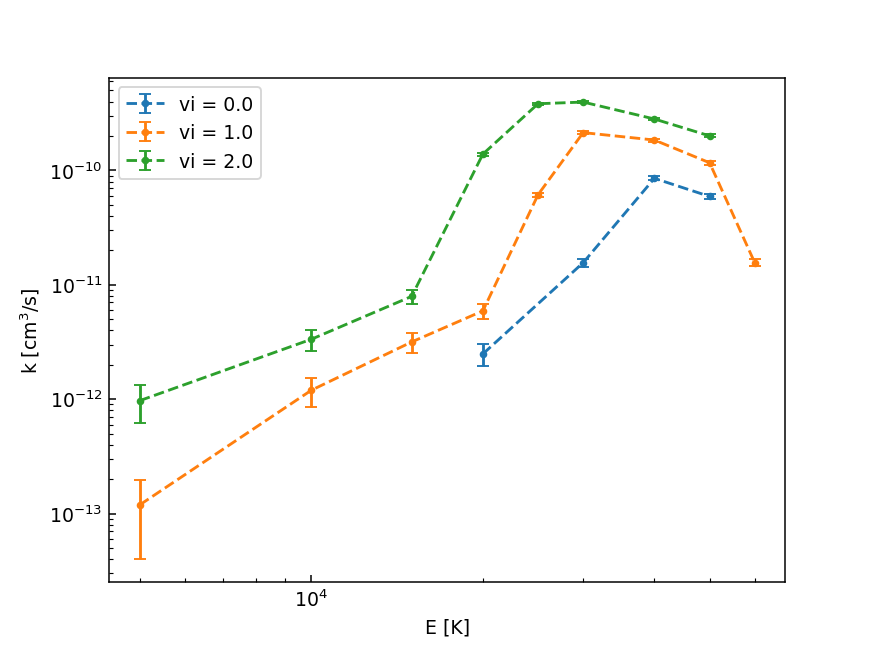

In [23]:
plt.figure()
for v in rates.vi.unique():
    r = rates[rates['vi']==v]
    plt.errorbar(r['e'],r['k_R'],r['k_Rerr'],fmt='.--',capsize=3, label = f'vi = {v}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E [K]')
plt.ylabel(r'k [$\mathrm{cm^3/s}$]')
plt.legend()
plt.tick_params(which='both',direction='in')
plt.show()